# Run a Simulation with a single defect created by an odd number of particles
* Constant frequency $f$, Packing $\Phi$, and height $h$. 
* Varying tilt angle $\delta$. 

Saved in 

    ../Data/Run2-OddRun

In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
directory = "../Data/Run2-OddRun"
os.system("rm -r %s"%directory)

0

In [3]:
h = 3.9*ureg.um
rho = 1.4 * ureg.um

region, positions = mgc.ordered_dimers(
    n_of_particles = 250,
    packing=0.35, height = h.magnitude,
    r = rho.magnitude, theta = 0)

### Delete a single object from the center

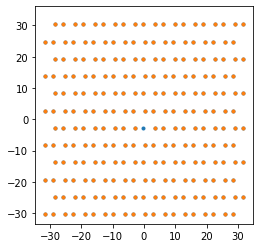

In [4]:
plt.plot(positions[:,0],positions[:,1],'.')
plt.axis("square")

mask = np.ones_like(positions[:,0], dtype=bool)
mask[np.argmin(np.sqrt(positions[:,0]**2+positions[:,1]**2))]=False

positions_new = positions[mask]


plt.plot(positions_new[:,0], positions_new[:,1],'.')

In [5]:
particles = mgc.particles(
    positions_new*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.073*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In [6]:
def redefine_field(field,tilt_angle):
    field.fieldx = 'v_Bmag*(sin(v_freq*time*2*PI)*sin(v_theta)+cos(v_theta)*%s)'%np.sin(tilt_angle).magnitude
    field.fieldy = 'v_Bmag*(cos(v_freq*time*2*PI)*sin(v_theta))'%np.sin(tilt_angle).magnitude
    field.fieldz = 'v_Bmag*(cos(v_theta)*%s)'%np.cos(tilt_angle).magnitude
    return field

In [7]:
world = mgc.world(particles, temperature = 300*ureg.K,
                  lj_parameters = [1e-2*ureg.pg*ureg.um**2/ureg.us**2, 2**(-1/6)],
                  region=region*ureg.um, boundaries = ['p','p','f'], 
                  walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

total_time = 60*ureg.s
tilt_angle = np.arange(0,30,1)

In [8]:
index_name = "index.dat"

import csv

def prepare_simulation(delta):
    
    field = mgc.field(magnitude = 7.28*ureg.mT, frequency = 3*ureg.Hz,
                  angle = 27*ureg.degrees, multibody_iter=2)
    
    field = redefine_field(field,delta*ureg.deg)

    sim = mgc.sim(dir_name = directory,
                  file_name="Tilt_%s_deg_h%u"%(delta,h.to(ureg.nm).magnitude),stamp_time=True,
                  timestep = 1e-4*ureg.s, framerate = 60*ureg.Hz, total_time = total_time,
                  particles = particles, world = world, 
                  field = field, output=["x","y","z","mux","muy","muz","fx","fy"])
    
    sim.tilt = delta
    sim.height = h
    
    return sim

In [9]:
simulations = [prepare_simulation(delta) for delta in tilt_angle[:]]

In [10]:
def run_simulation(sim):
    
    import csv
    import os
    index_name = "index.dat"
    directory = sim.dir_name
    
    sim.generate_scripts()
    sim.run()
    
    sim.load()
    max_frame = max(sim.lazy_read.T.keys())
    
    h = sim.height
    delta = sim.tilt
    
    with open(os.path.join(directory,index_name),'a',newline='') as file:
        writer = csv.writer(file,delimiter=' ')
        writer.writerow([os.path.split(sim.base_name)[-1], h.magnitude, delta, max_frame])

## Run Asynchronously

In [11]:
from multiprocessing import Pool

In [ ]:
%%time
if __name__ ==  '__main__': 
    num_processors = 30
    p=Pool(processes = num_processors)
    p.map(run_simulation,simulations)

In [ ]:
index = pd.read_csv(os.path.join(directory,"index.dat"),
                    names = ["file", "height", "tilt", "max_frame"],
                    sep=" ")

In [ ]:
index.head()

In [ ]:
name = index.query("tilt == 10").iloc[0].file

In [ ]:
trj_read = mgc.trj_lazyread(os.path.join(directory,name+".lammpstrj"), 
                     output = ["x","y","z","mux","muy","muz","fx","fy"])
trj = trj_read[:]
bounds = trj_read.get_bounds()

In [ ]:
trj.head()

In [ ]:
frames = trj.index.get_level_values("frame").unique()
anim = mgc.animate_trj(trj.loc[frames[:100]],
                       region = bounds.iloc[0], radius = 1.4,
                       framerate = 20, verb = False)

In [ ]:
vid = anim.to_html5_video()

In [ ]:
HTML(vid)

In [ ]:
index